In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def mean_fun(x,b0,b1):
    return b0+b1*x

def cov_fun(x,var,offset):
    return np.matrix(var*(x-offset)*(x.T-offset))

def likelihood(mean,cov,y,noise):
    cov+=np.identity(len(y))*noise
    return (1/np.sqrt((2*np.pi)**len(x)*np.linalg.det(cov))) * np.exp(-.5*(y-mean).T*np.linalg.inv(cov)*(y-mean))

In [2]:
def method1(experts,priors,x,y,noise):
    '''
    Assigns x/y pairs to experts iteratively, updating means and covariances for each expert with each new assignment
    Input:
        experts: GP experts defined by mean/covariance function pairs
        priors: probability assigned to each expert
        x/y: training data
        noise: added to diagonals of cov matrices
    Output:
        x and y values assigned to each expert
    '''
    #initialize x and y values assigned to each expert as empty sets
    x_assignments=[[] for j in experts]
    y_assignments=[[] for j in experts]
    #iterate over training data
    for i in xrange(len(x)):
        #calculate temporary means and covariances, determined for each expert as if x[i] has already been assigned
        x_temp=[x_assignments[j]+[x[i]] for j in xrange(len(experts))]
        means_temp=[mean_fun(np.array(x_temp[j]),*experts[j][0]) for j in xrange(len(experts))]
        covs_temp=[cov_fun(np.array(x_temp[j]),*experts[j][1]) for j in xrange(len(experts))]
        #calculate temporary set of y partitions, determined for each expert as if y[i] has already been assigned
        y_temp=[y_assignments[j]+[y[i]] for j in xrange(len(experts))]
        #determine the likelihood of each temporary partition of y for each expert
        likelihoods=[likelihood(means_temp[j],covs_temp[j],y_temp[j],noise) for j in xrange(len(experts))]
        #weigh likelihoods by priors
        proportions=[likelihoods[j]*priors[j] for j in xrange(len(experts))]
        factor=sum(proportions)
        posteriors=[(p/factor).sum() for p in proportions]
        #draw an expert from the posterior and assign to it x[i] and y[i]
        draw=list(np.random.choice(range(len(experts)),1,p=posteriors))[0]
        x_assignments[draw].append(x[i])
        y_assignments[draw].append(y[i])
    return [np.array(x_assignments[j]) for j in xrange(len(experts))],[np.array(y_assignments[j]) for j in xrange(len(experts))]

noise = 0.1


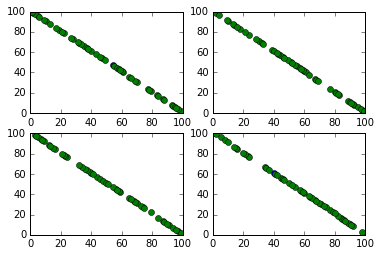

noise = 1


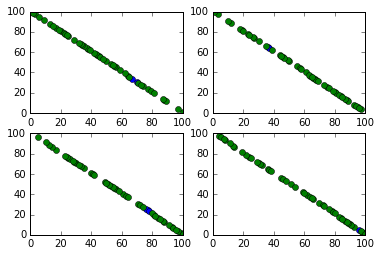

noise = 10


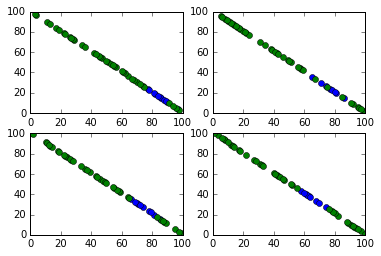

In [3]:
#experts with fixed mean and covariance hyperparameters. Covariance hyperparameters will be optimized in the full model.
PL=((0,1),(1,0))
NL=((101,-1),(1,0))

for noise in [.1,1,10]:
    fig,axes=plt.subplots(2,2)

    for n in xrange(2):
        for m in xrange(2):
            x=np.random.choice(np.linspace(1,100,100),50,replace=False)[None].T
            y=101-x

            x_assignments,y_assignments=method1((PL,NL),(.88,.11),x,y,noise)
            for i in xrange(len(x_assignments)):
                axes[n][m].plot(x_assignments[i],y_assignments[i],'o')
    print 'noise = {0}'.format(noise)
    plt.show()

### Notes on method 1

* I was anticipating that the likelihoods of assigning points close to (50,50) would be similar for the PL and NL experts, but this is more dependent on previous assignments then I thought it would be. As is, one of the first few points always ends up with a high likelihood of being assigned to PL regardless of position, and then subsequent assignments depend on proximity to that first point.

* Joe was telling me that importance sampling might be able to resolve this by weeding out these inital assignments that are not close to (50,50), but I haven't been able to figure out how to assign weights to each model such that those that assign inputs to experts that are relatively unlikely given their mean function (e.g. assigning (100,1) to PL even though m(100)=100) are penalized.

In [4]:
def method2(experts,priors,x,y,noise):
    '''
    Assign x/y pairs to experts iteratively, without taking into account previous assignments
    Input:
        experts: GP experts defined by mean/covariance function pairs
        priors: probability assigned to each expert
        x/y: training data
        noise: variance of the 1d Gaussian used to determine likelihoods of individual x/y pairs
    Output:
        x and y values assigned to each expert
    '''
    #initialize x and y values assigned to each expert as empty sets
    x_assignments=[[] for j in experts]
    y_assignments=[[] for j in experts]
    #iterate over training data
    for i in xrange(len(x)):
        #determine the likelihood of y[i] given the mean of each expert at x[i]
        likelihoods=[likelihood(mean_fun(x[i],*experts[j][0]),noise,y[i],0) for j in xrange(len(experts))]
        #weigh likelihoods by priors
        proportions=[likelihoods[j]*priors[j] for j in xrange(len(experts))]
        factor=sum(proportions)
        posteriors=[(p/factor).sum() for p in proportions]
        #draw an expert from the posterior and assign to it x[i] and y[i]
        draw=list(np.random.choice(range(len(experts)),1,p=posteriors))[0]
        x_assignments[draw].append(x[i])
        y_assignments[draw].append(y[i])
    return [np.array(x_assignments[j]) for j in xrange(len(experts))],[np.array(y_assignments[j]) for j in xrange(len(experts))]

noise = 0.1


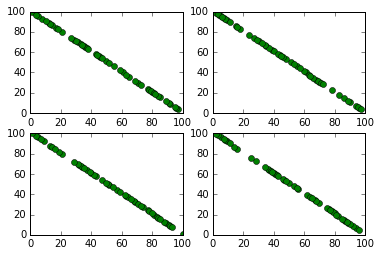

noise = 1


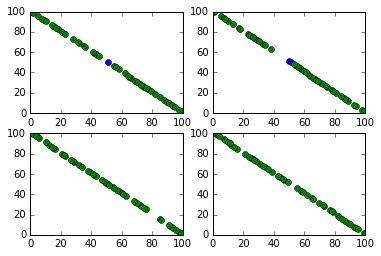

noise = 10


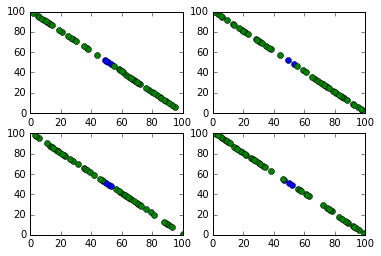

In [5]:
for noise in [.1,1,10]:
    fig,axes=plt.subplots(2,2)

    for n in xrange(2):
        for m in xrange(2):
            x=np.random.choice(np.linspace(1,100,100),50,replace=False)[None].T
            y=101-x

            x_assignments,y_assignments=method2((PL,NL),(.88,.11),x,y,noise)
            for i in xrange(len(x_assignments)):
                axes[n][m].plot(x_assignments[i],y_assignments[i],'o')
    print 'noise = {0}'.format(noise)
    plt.show()

### Notes on method 2

* This will only work in our model if the two mean functions are different, which is only the case for PL and NL. It wouldn't be able to, for instance, model two overlapping SE kernels with different length scales. I think we're really only concerned with knowledge partitioning between linear functions with positive and negative slopes anyway, so maybe it's good enough.